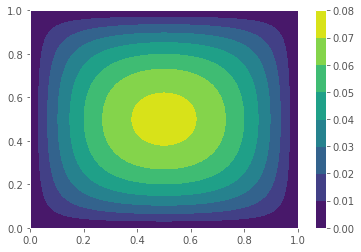

In [89]:
import numpy
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.sparse
%matplotlib inline
from matplotlib import pyplot
pyplot.style.use('ggplot')

# From FD2D notebook
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def nonlinear2d_div(h, x, y, u, forcing, g0, dirichlet=((),()), p=1, epsilon=0.1):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            # Stencil to evaluate gradient at four staggered points
            grad = numpy.array([[-1, 0, 1, 0, 0],
                                [0, -1, 1, 0, 0],
                                [0, 0, -1, 1, 0],
                                [0, 0, -1, 0, 1]]) / h
            # Stencil to average at four staggered points
            avg  = numpy.array([[1, 0, 1, 0, 0],
                                [0, 1, 1, 0, 0],
                                [0, 0, 1, 1, 0],
                                [0, 0, 1, 0, 1]]) / 2
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            ustag = avg @ ustencil
            # kappa = (1 + ustag**2)[:,None]
            # kappa = (1/2 e^2 + 1/2 grad u dot grad u)^(p-2/2)
            kappa = (.5 * epsilon ** 2 + .5 * (grad @ ustencil).dot(grad @ ustencil)) ** (p-2/2)
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa * grad @ ustencil)
                Jstencil = -div @ (kappa * grad)
                    #+ 2*(ustag*(grad @ ustencil))[:,None] * avg)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csc_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

h = .02
x, y = hgrid(h)
u = 0*x
F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x,
                       p=1, epsilon=0.1,
                       dirichlet=((0,-1),(0,-1)))
deltau = sp.linalg.spsolve(J, -F).reshape(x.shape)
pyplot.contourf(x, y, deltau)
pyplot.colorbar();

The Picard solver converges fastest when $p$ is $1$ and $\epsilon$ is larger than $1$. If $\epsilon$ becomes too small, then the solver fails to converge (this depends on $p$). Larger values of $p$ take longer to solve.

Picard solver
 0: anorm 1.000000e+00
 1: anorm 8.020379e+00
 2: anorm 8.147237e-01
 3: anorm 1.418848e+00
 4: anorm 4.123252e-01
 5: anorm 2.816190e-01
 6: anorm 1.126161e-01
 7: anorm 5.240071e-02
 8: anorm 2.118671e-02
 9: anorm 8.556565e-03
10: anorm 3.298630e-03
11: anorm 1.246353e-03
12: anorm 4.598816e-04
13: anorm 1.667610e-04
14: anorm 5.961129e-05
15: anorm 2.125501e-05
16: anorm 7.478820e-06
17: anorm 2.601389e-06
18: anorm 8.957531e-07
19: anorm 3.057010e-07
Preconditioning with Picard
 0: anorm 1.000000e+00
 1: anorm 7.742462e+00
 2: anorm 1.999391e+00
 3: anorm 2.493098e-01
 4: anorm 1.947916e-02
 5: anorm 3.073153e-03
 6: anorm 5.020951e-04
 7: anorm 8.432547e-05
 8: anorm 1.437862e-05
 9: anorm 2.485855e-06
10: anorm 2.485855e-06
11: anorm 2.485855e-06
12: anorm 2.485855e-06
13: anorm 2.485855e-06
14: anorm 2.485855e-06
15: anorm 2.485855e-06
16: anorm 2.485855e-06
17: anorm 2.485855e-06
18: anorm 2.485855e-06
19: anorm 2.485855e-06
Difference between solutions: 1.709511

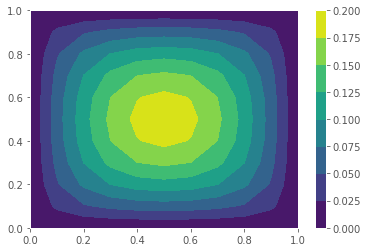

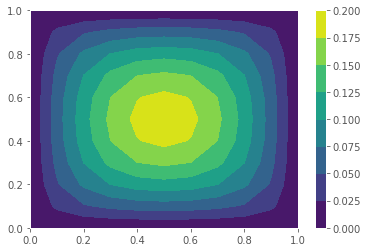

In [99]:
def solve_nonlinear(h, g0, dirichlet, p, epsilon, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(20):
        F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, p=p, epsilon=epsilon, dirichlet=((0,-1),(0,-1)))
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)
    return x, y, u, i

def solve_nonlinear_preconditioned(h, g0, dirichlet, p, epsilon, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(20):
        F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, p=p, epsilon=epsilon, dirichlet=((0,-1),(0,-1)))
        def J_tilde(v):
            Fv, _ = nonlinear2d_div(h, x, y, u + h * v.reshape(u.shape), lambda x,y: 0*x+1,
                                   lambda x,y: 0*x, p=p, epsilon=epsilon, dirichlet=((0,-1),(0,-1)))
            return (Fv - F)/h
            
        lo = scipy.sparse.linalg.LinearOperator(J.shape, matvec=J_tilde)
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        J_inv = scipy.sparse.linalg.factorized(J)
        M = scipy.sparse.linalg.LinearOperator(J.shape, matvec=J_inv)
        deltau, info = sp.linalg.gmres(lo, -F, M=M)
        assert(info == 0)
        u += deltau.reshape(x.shape)
    return x, y, u, i

h = 0.1
p = 3
epsilon = 1

print("Picard solver")
x, y, u1, i = solve_nonlinear(h, lambda x,y: 0*x, ((0,-1),(0,-1)), p, epsilon, verbose=True)
print("Preconditioning with Picard")
x, y, u2, i = solve_nonlinear_preconditioned(h, lambda x,y: 0*x, ((0,-1),(0,-1)), p, epsilon, verbose=True)
print("Difference between solutions: {}".format(numpy.linalg.norm(u1-u2, numpy.inf)))

Using Picard as a preconditioner results in faster convergence compared the Picard solver. Implementing the full Jacobian would require symbolically computing the Jacobian of $ -\nabla\cdot\big( \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}} \nabla u \big) $ and adding it to the code. Convergence with the full Jacobian should be quadratic.